In [67]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_table("rotatingHyperplane.data",sep=" ",header=-1)
labels=pd.read_table("rotatingHyperplane.labels",sep=" ",header=-1)

In [3]:
first_10 = data.loc[0:data.shape[0]*0.1,]
first_10_y = labels.loc[0:data.shape[0]*0.1,]
last_10 = data.iloc[int(data.shape[0]*0.9):,]
last_10_y = labels.iloc[int(data.shape[0]*0.9):,]

In [4]:
data.describe()

,0,1,2,3,4,5,6,7,8,9
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.500455,0.500036,0.500663,0.499870,0.499616,0.499675,0.499980,0.499457,0.499166,0.500652
std,0.288661,0.288639,0.288392,0.288994,0.288632,0.289000,0.288800,0.288432,0.288709,0.288756
min,0.000010,0.000004,0.000006,0.000005,0.000002,0.000002,0.000001,0.000010,0.000004,0.000013
25%,0.250671,0.250297,0.251419,0.249914,0.250228,0.249412,0.249528,0.249776,0.249039,0.250440
50%,0.501092,0.500935,0.500997,0.499323,0.499553,0.498717,0.500364,0.500212,0.498059,0.500957
75%,0.749778,0.749462,0.749945,0.751161,0.749232,0.750109,0.750240,0.749472,0.749975,0.750482
max,0.999998,0.999999,0.999990,0.999985,1.000000,0.999995,0.999998,0.999997,0.999980,0.999999


Wartości każdej z roważanych zmiennych mieszczą się w przedziale [0,1] zatem zaklasyfikujemy wartości każdej z nich do jednego z koszyków [0,0.1],[0.1,0.2],...,[0.9,1] i w ten sposób porównany rozkład zmiennej pomiędzy danymi pochodzącymi z pierwszych 10% obserwacji, a tymi pochodzącymi z 10 ostatnich.

Funkcja pomocnicza zwracająca frakcję obserwacji zawartych w każdym z koszyków:

In [50]:
def bins_perc(data,i,n):
    return pd.cut(data.iloc[:,i],n).value_counts()[pd.cut(data.iloc[:,i],n).value_counts().index.sort_values()]/data.shape[0]

In [53]:
bins_perc(data,0,10)

(-0.00099, 0.1]    0.100220
(0.1, 0.2]         0.099610
(0.2, 0.3]         0.098850
(0.3, 0.4]         0.100390
(0.4, 0.5]         0.099795
(0.5, 0.6]         0.099770
(0.6, 0.7]         0.100455
(0.7, 0.8]         0.101245
(0.8, 0.9]         0.099665
(0.9, 1.0]         0.100000
Name: 0, dtype: float64

In [56]:
def lag(first,last,i,n):
    return round(sum([abs(k) for k in (bins_perc(first,i,n).values-bins_perc(last,i,n).values)]),2)

In [57]:
for i in range(data.shape[1]):
    print("Zmienność w zmiennej "+str(i)+": "+str(lag(first_10,last_10,i,10)))

Zmienność w zmiennej 0: 0.02
Zmienność w zmiennej 1: 0.02
Zmienność w zmiennej 2: 0.02
Zmienność w zmiennej 3: 0.04
Zmienność w zmiennej 4: 0.03
Zmienność w zmiennej 5: 0.04
Zmienność w zmiennej 6: 0.02
Zmienność w zmiennej 7: 0.03
Zmienność w zmiennej 8: 0.02
Zmienność w zmiennej 9: 0.02


We wszystkich zmiennych otrzymaliśmy sumaryczne zmienności wewnątrz koszyków bliskie 0, więc można uznać, że rozkłady pojedynczych zmiennych są stacjonarne.

## Modele

In [10]:
X_train, X_test, y_train, y_test = train_test_split( first_10, first_10_y, test_size=0.4, random_state=623)

In [11]:
model = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)

C:\Users\joann\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wyznaczę rezydua na zbiorze testowym pochodzącym z próbki pierwszych 10% obserwacji oraz rezydua z próbki ostatnich 10% obserwacji

In [46]:
res_train = pd.DataFrame(y_test.transpose().iloc[0,:]-model.predict_proba(X_test)[:,1])

In [47]:
res_test = pd.DataFrame(last_10_y.transpose().iloc[0,:]-model.predict_proba(last_10)[:,1])

Policzę skumulowaną zmienność wewnątrz koszyków, tak jak w przypadku samych wartości zmiennych

In [60]:
lag(res_train,res_test,0,20)

0.5

Jak widać predykcja bardzo różni się względem zbiorów co świadczy o zmianie charakteru danych pochodzących z ostatnich 10%, względem danych pochodzących z pierwszych 10% obserwacji.

Dopasuję model na ostatnich 10% obserwacji

In [80]:
X_train2, X_test2, y_train2, y_test2 = train_test_split( last_10, last_10_y, test_size=0.4, random_state=623)

In [81]:
model2 = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train2, y_train2)

C:\Users\joann\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
model2.coef_

array([[ 1.84410359,  0.70824904, -1.09907405, -0.96919529,  3.54497144,
        -2.10487797,  1.33859354,  0.70189437,  1.89657286, -0.26221864]])

In [62]:
model.coef_

array([[2.17829517, 1.55720401, 1.15486813, 1.04266453, 2.09401546,
        1.2461101 , 1.98580167, 1.55174562, 2.06397124, 2.32035147]])

Można zauważyć, że współczynniki obu modeli znacznie się od siebie różnią, co potwierdza przypuszczenia o zmianie charakteru danych wraz z czasem.

## PDP

In [109]:
def PD(model1,model2, index, points, X,X_last,h):
    Tab=X.copy()
    prob=list()
    for point in points:
        Tab.iloc[:,index]=[point]*Tab.shape[0]
        prob.append(pd.DataFrame(model1.predict_proba(Tab)).iloc[:,0].mean())
    plt.plot(points, prob,label="model1")
    Tab=X_last.copy()
    prob2=list()
    for point in points:
        Tab.iloc[:,index]=[point]*Tab.shape[0]
        prob2.append(pd.DataFrame(model2.predict_proba(Tab)).iloc[:,0].mean())
    area = sum([abs(prob[i]-prob2[i])*h for i in range(len(prob))])
    plt.plot(points, prob2,label="model2")
    plt.fill_between(points, prob, prob2, color = 'lightpink', alpha = 0.4, hatch = '-')
    plt.legend(loc='upper right')
    plt.title("PDP dla zmiennej "+str(index)+", pole = "+str(round(area,2)))
    plt.show()

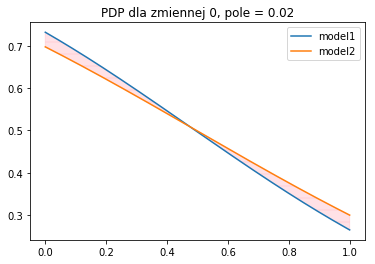

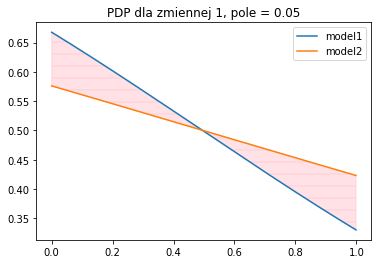

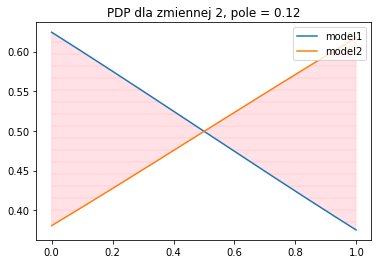

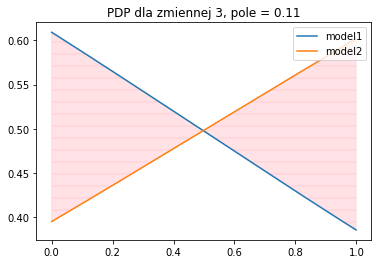

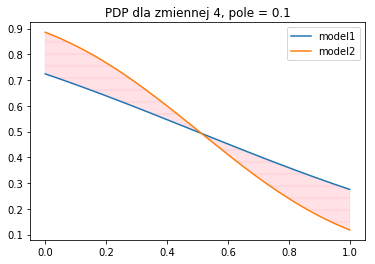

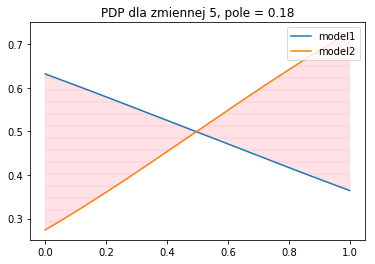

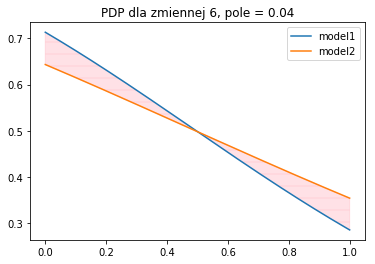

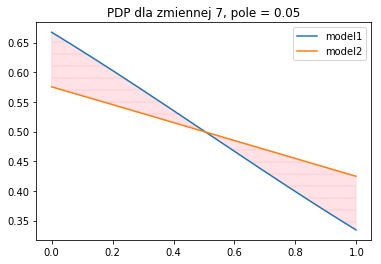

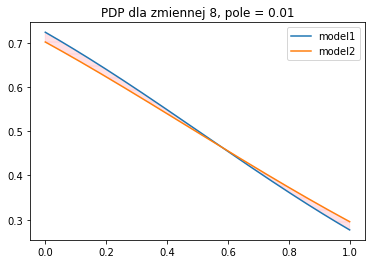

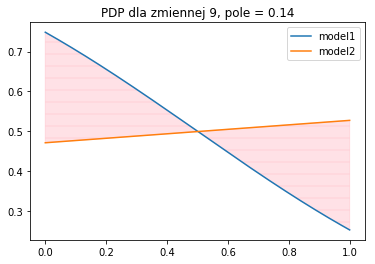

In [110]:
for i in range(10):
    PD(model,model2,i,np.arange(0, 1, 0.001),X_test,X_test2,0.001)

Powyższe wykresy potwierdzają wcześniejsze obserwacje o zmianie charakteru danych. Największe różnice widać w zmienej 2,3,5 oraz 9.